In [30]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import OrderedDict
import plotly.graph_objects as go

from trainer import Trainer

# Generate data

In [31]:
X = torch.linspace(-torch.pi, torch.pi, 100)
Y = torch.sin(X) + torch.normal(mean=0, std=torch.full(X.shape, 0.05))
tr_data = torch.stack([X, Y], dim=1)

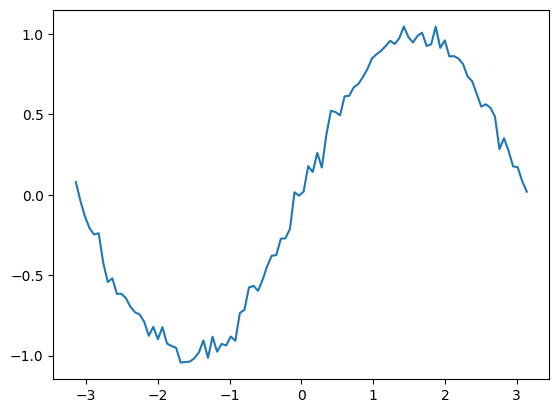

In [32]:
plt.plot(X, Y)
plt.show()

# Model

In [33]:
class SimpleModel(nn.Module):
    """
    Simple model for testing
    """
    def __init__(self, output_dim: int):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                                 nn.LazyLinear(4), nn.ReLU(),
                                 )
        self.last_proj = nn.LazyLinear(output_dim)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.last_proj(self.net(X))

    def loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        loss_fn = nn.MSELoss()
        return loss_fn(y_hat, y)

In [34]:
model=SimpleModel(output_dim=1)

/Users/dmitripedchenko/miniconda3/envs/loss_func/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



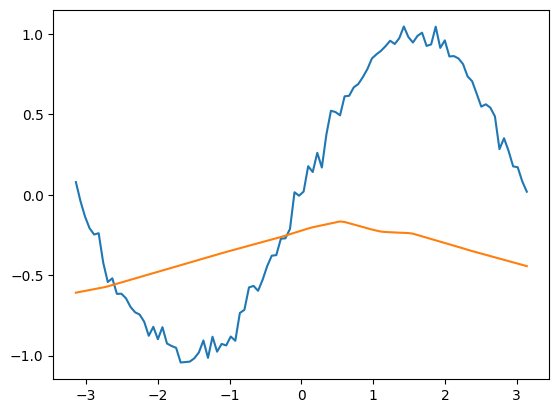

In [35]:
plt.plot(X,Y)
plt.plot(X, model(X.reshape(-1, 1)).detach())
plt.show()

Train

In [36]:
trainer = Trainer(train_epochs=10_000, lr = 0.1)

In [37]:
trainer.train(model, tr_data, print_epoch=1_000)

Training epoch 0
Training epoch 1000
Training epoch 2000
Training epoch 3000
Training epoch 4000
Training epoch 5000
Training epoch 6000
Training epoch 7000
Training epoch 8000
Training epoch 9000


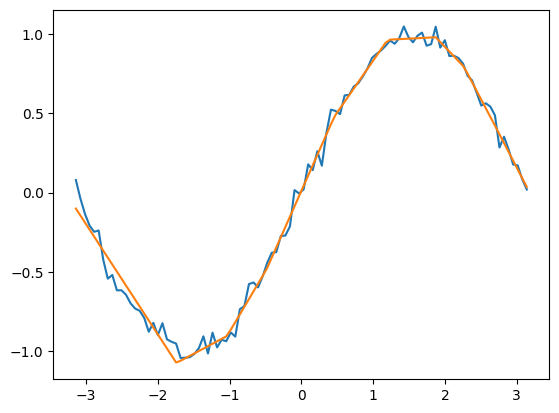

In [38]:
plt.plot(X,Y)
plt.plot(X, model(X.reshape(-1, 1)).detach())
plt.show()

# Plot of loss function as the function of model parameters

## Plot function along a direction vector in param space

In [39]:
model.eval()
trained_weights = model.state_dict()
trained_weights

OrderedDict([('net.0.weight',
              tensor([[-0.3580],
                      [-0.2539],
                      [ 0.6280],
                      [-1.0581],
                      [-0.2234],
                      [-0.1427],
                      [ 0.8654],
                      [-0.7340]])),
             ('net.0.bias',
              tensor([ 0.8290, -0.2028,  0.6499, -0.5116,  0.8721,  0.3843, -1.0410,  0.3381])),
             ('net.2.weight',
              tensor([[-0.0719,  0.3098,  0.2061,  0.3127, -0.3346,  0.0978,  0.4997,  0.0129],
                      [-0.0270, -0.3097, -0.4258, -0.6135,  0.3915,  0.2725,  0.1967,  0.2222],
                      [ 0.1259, -0.3117,  0.2420, -0.6339,  0.4284, -0.0082, -0.4820, -0.3703],
                      [ 0.4652, -0.1914, -0.4111, -0.7036,  0.2331,  0.3436,  0.1233, -0.0324]])),
             ('net.2.bias', tensor([-0.5138,  0.5446,  0.7984,  0.6272])),
             ('last_proj.weight',
              tensor([[-0.7666, -0.6015,  1.0609, -0

Randomly init direction vector

In [40]:
dir_vec = OrderedDict(
    (name, torch.normal(mean=0, std=torch.full(t.shape, 0.01)))
    for name, t in trained_weights.items()
)
dir_vec

OrderedDict([('net.0.weight',
              tensor([[ 0.0063],
                      [ 0.0082],
                      [ 0.0104],
                      [-0.0016],
                      [-0.0049],
                      [ 0.0038],
                      [-0.0118],
                      [-0.0036]])),
             ('net.0.bias',
              tensor([-0.0107, -0.0139,  0.0090,  0.0180,  0.0103, -0.0013, -0.0019, -0.0006])),
             ('net.2.weight',
              tensor([[ 0.0026, -0.0169,  0.0123, -0.0225,  0.0038, -0.0017,  0.0089,  0.0037],
                      [-0.0015,  0.0112,  0.0037,  0.0100, -0.0051, -0.0109, -0.0069, -0.0022],
                      [-0.0005,  0.0144, -0.0124, -0.0056, -0.0033,  0.0036,  0.0009, -0.0078],
                      [ 0.0055,  0.0055,  0.0091,  0.0133,  0.0041, -0.0139, -0.0030, -0.0076]])),
             ('net.2.bias', tensor([-0.0125, -0.0154, -0.0060, -0.0187])),
             ('last_proj.weight',
              tensor([[ 0.0047, -0.0032, -0.0231,  0

In [41]:
line_param =  torch.linspace(-1, 1, steps=100)
losses = []
for param in line_param:
    scaled_dir_vec = OrderedDict(
        (name, param * t) for name, t in dir_vec.items()
    )
    model.load_state_dict(scaled_dir_vec)
    losses.append(model.loss(model(tr_data[:, :-1]).squeeze(), Y).detach())

Good, we are near a minimum in this direction, and the function is nice and convex.

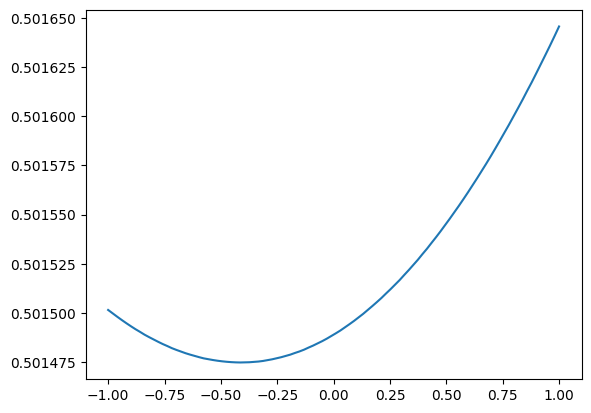

In [42]:
plt.plot(line_param, losses)
plt.show()

## Plot along a direction plane

In [43]:
dir_vec1 = OrderedDict(
    (name, torch.normal(mean=0, std=torch.full(t.shape, 0.01)))
    for name, t in trained_weights.items()
)
dir_vec2 = OrderedDict(
    (name, torch.normal(mean=0, std=torch.full(t.shape, 0.01)))
    for name, t in trained_weights.items()
)

In [44]:
x_param = torch.linspace(-1, 1, steps=100)
y_param = torch.linspace(-1, 1, steps=100)
# grid_x, grid_y = torch.meshgrid(x_param, y_param)

In [45]:
losses_3d = []
for x in x_param:
    for y in y_param: 
        z = OrderedDict(
            (name, x* dir_vec1[name] + y* dir_vec2[name]) 
            for  name in trained_weights.keys()
            )
        model.load_state_dict(z)
        losses_3d.append(model.loss(model(tr_data[:, :-1]).squeeze(), Y).detach())

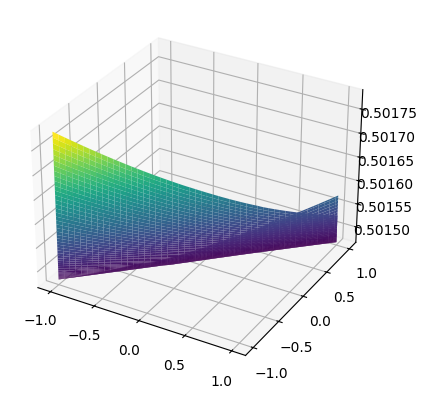

In [46]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(x_param, y_param, torch.tensor(losses_3d).reshape(100, 100), cmap="viridis")
plt.show()

In [47]:
fig = go.Figure(go.Surface(x=x_param, y=y_param, z=torch.tensor(losses_3d).reshape(100, 100)))
fig.update_layout(width=1_200, height=600)
fig.show()